# Classification Outlier Detection On Simulted Data

### Imports

In [14]:
%matplotlib inline
import math
import random
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pickle
import ddks
from sklearn import metrics
from sklearn.decomposition import PCA

import torchvision.transforms as T

from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
import time
import random
import pickle
random.seed(1)

import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from sklearn.model_selection import train_test_split

writer = SummaryWriter()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print(torch.cuda.is_available())

plt.rcParams['text.usetex'] = True
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

False


### Data

In [2]:
def simulate_from_bi_normal(mean, sigma, n, class_number, r_seed=1):
    np.random.seed(r_seed)
    # Step 1
    U = np.random.standard_normal(size=(n, 2))
    
    sigma_root = np.linalg.cholesky(sigma)
    sigma_check = sigma_root @ sigma_root.T
    if not np.allclose(sigma_check, sigma):
        print(f"Sigma_check is not equal sigma")
    
    # Step 2
    W = U @ sigma_root
    
    # Step 3
    y_1 = np.array(W[:, 0])
    y_2 = np.array(W[:, 1])
    
    # Step 4
    y_1 = np.array([float(y_1i + mean[0]) for y_1i in np.array(W[:, 0])])
    y_2 = np.array([float(y_2i + mean[1]) for y_2i in np.array(W[:, 1])])
    class_array = np.full(n, class_number)
    
    return np.column_stack((y_1, y_2, class_array))


# Class 1
mean_k = np.matrix([[-2.], [2.]])
sigma_k = np.matrix([
    [0.5, 0],
    [0, 0.5]])

# Class 2
mean_l = np.matrix([[2.], [2.]])
sigma_l = np.matrix([
    [0.5, 0],
    [0, 0.5]])

# Class 3
mean_m = np.matrix([[2.], [-2.]])
sigma_m = np.matrix([
    [0.5, 0],
    [0, 0.5]])

# Class 4
mean_n = np.matrix([[-2.], [-2.]])
sigma_n = np.matrix([
    [0.5, 0],
    [0, 0.5]])

minmaxscaler = MinMaxScaler(feature_range=(0, 1))
n_samples_200 = int(200)
k = simulate_from_bi_normal(mean_k, sigma_k, n_samples_200, 0, r_seed=1)
l = simulate_from_bi_normal(mean_l, sigma_l, n_samples_200, 1, r_seed=2)
m = simulate_from_bi_normal(mean_m, sigma_m, n_samples_200, 2, r_seed=3)
n = simulate_from_bi_normal(mean_n, sigma_n, n_samples_200, 3, r_seed=4)

# Add to one matrix and maxmin-scale:
data_4_200_unscaled = np.concatenate((k, l, m, n), axis=0)
minmaxscaler.fit(data_4_200_unscaled) 
data_4_200 = minmaxscaler.transform(data_4_200_unscaled)

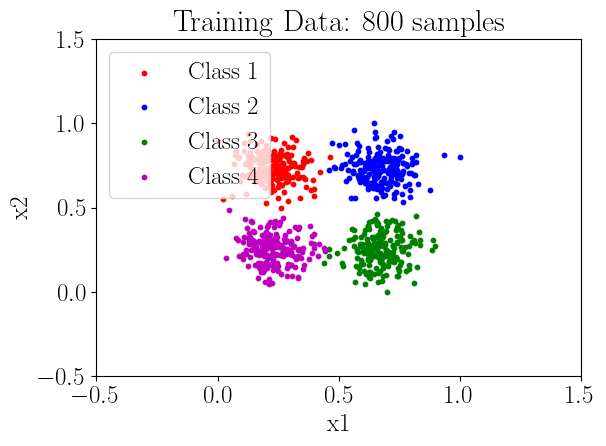

In [12]:
fig, ax = plt.subplots(1, 1)

ax.scatter(data_4_200[:n_samples_200, 0], data_4_200[:n_samples_200, 1], s=10, c='r', marker="o", label='Class 1')
ax.scatter(data_4_200[n_samples_200:n_samples_200*2, 0], data_4_200[n_samples_200:n_samples_200*2, 1], s=10, c='b', marker="o", label='Class 2')
ax.scatter(data_4_200[n_samples_200*2:n_samples_200*3, 0], data_4_200[n_samples_200*2:n_samples_200*3, 1], s=10, c='g', marker="o", label='Class 3')
ax.scatter(data_4_200[n_samples_200*3:n_samples_200*4, 0], data_4_200[n_samples_200*3:n_samples_200*4, 1], s=10, c='m', marker="o", label='Class 4')
ax.title.set_text(f"Training Data: 800 samples")
ax.set_xlabel("x1"), ax.set_ylabel("x2")
ax.legend(loc='upper left')

plt.ylim((-0.5, 1.5))
plt.xlim((-0.5, 1.5))
plt.tight_layout()
plt.show();

In [3]:
# Class 1
mean_1 = np.matrix([[-0.2], [1.2]])
sigma_1 = np.matrix([
    [0.005, 0],
    [0, 0.005]])

# Class 2
mean_2 = np.matrix([[1.2], [-0.2]])
sigma_2 = np.matrix([
    [0.005, 0],
    [0, 0.005]])

# Class 3
mean_3 = np.matrix([[1.2], [1.2]])
sigma_3 = np.matrix([
    [0.005, 0],
    [0, 0.005]])

# Class 4
mean_4 = np.matrix([[-0.2], [-0.2]])
sigma_4 = np.matrix([
    [0.005, 0],
    [0, 0.005]])

# Class 4
mean_5 = np.matrix([[0.5], [0.5]])
sigma_5 = np.matrix([
    [0.005, 0],
    [0, 0.005]])


minmaxscaler = MinMaxScaler(feature_range=(0, 1))
n_samples = int(50)
s_1 = simulate_from_bi_normal(mean_1, sigma_1, n_samples, 5, r_seed=5)
s_2 = simulate_from_bi_normal(mean_2, sigma_2, n_samples, 6, r_seed=6)
s_3 = simulate_from_bi_normal(mean_3, sigma_3, n_samples, 7, r_seed=7)
s_4 = simulate_from_bi_normal(mean_4, sigma_4, n_samples, 8, r_seed=8)
s_5 = simulate_from_bi_normal(mean_5, sigma_5, n_samples, 9, r_seed=9)

ood_and_ib = np.concatenate((s_1, s_2, s_3, s_4, s_5), axis=0)

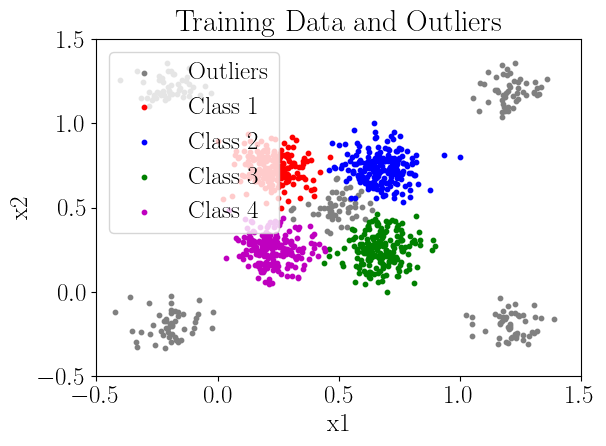

In [5]:
fig, ax = plt.subplots(1, 1)


ax.scatter(ood_and_ib[:, 0], ood_and_ib[:, 1], s=10, c='grey', marker="o", label='Outliers')
ax.scatter(data_4_200[:n_samples_200, 0], data_4_200[:n_samples_200, 1], s=10, c='r', marker="o", label='Class 1')
ax.scatter(data_4_200[n_samples_200:n_samples_200*2, 0], data_4_200[n_samples_200:n_samples_200*2, 1], s=10, c='b', marker="o", label='Class 2')
ax.scatter(data_4_200[n_samples_200*2:n_samples_200*3, 0], data_4_200[n_samples_200*2:n_samples_200*3, 1], s=10, c='g', marker="o", label='Class 3')
ax.scatter(data_4_200[n_samples_200*3:n_samples_200*4, 0], data_4_200[n_samples_200*3:n_samples_200*4, 1], s=10, c='m', marker="o", label='Class 4')
ax.title.set_text(f"Training Data and Outliers")
ax.set_xlabel("x1"), ax.set_ylabel("x2")
ax.legend(loc='upper left')


plt.ylim((-0.5, 1.5))
plt.xlim((-0.5, 1.5))
plt.tight_layout()
plt.show();

In [10]:
minmaxscaler = MinMaxScaler(feature_range=(0, 1))

X = data_4_200_unscaled[:, :2]
y = data_4_200_unscaled[:, 2]


minmaxscaler.fit(X)
X = minmaxscaler.transform(X)
X, y = torch.from_numpy(X).float(), torch.from_numpy(y).long() 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=10, stratify=y)
X_train.shape, y_train.shape


BATCH_SIZE = 10
TEST_BATCH_SIZE = 5


TRAIN_SIZE = len(X_train)
TEST_SIZE = len(X_test)


X_train = torch.split(X_train, BATCH_SIZE)
X_test = torch.split(X_test, TEST_BATCH_SIZE)
y_train = torch.split(y_train, BATCH_SIZE)
y_test = torch.split(y_test, TEST_BATCH_SIZE)


NUM_BATCHES = len(X_train)
NUM_TEST_BATCHES = len(X_test)

CLASSES = 4
TRAIN_EPOCHS = 10 
SAMPLES = int(len(X)*0.8) 
TEST_SAMPLES = int(len(X)*0.2)

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

### Model

In [13]:
# Follows implementation by: https://github.com/nitarshan/bayes-by-backprop/blob/master/Weight%20Uncertainty%20in%20Neural%20Networks.ipynb
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print(torch.cuda.is_available())

# Reparameterized Gaussian
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()
    
    
# Use a scaled mixture of two Gaussians for the prior distribution on the weights
# These prior parameters are fixed and will not change during training, we therefore
# dont need to use reparameterized Gaussian here:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()

PI = 0.5
SIGMA_1 = torch.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.FloatTensor([math.exp(-6)])


# Single bayesian network layer:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0
        
    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)
    
# Bayesian Neural Network consisting of two 2 fully connected layers:
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Flere nodes?
        self.l1 = BayesianLinear(2, 100)
        self.l2 = BayesianLinear(100, 100)
        self.l3 = BayesianLinear(100, 4)
    
    def forward(self, x, sample=False, return_pre=False):
        x = x.view(-1, 2)
        x = F.relu(self.l1(x, sample))
        x = F.relu(self.l2(x, sample))
        x_pre = self.l3(x, sample)
        x = F.softmax(x_pre, dim=1)
        # Velger om man vil returnere pre activation neuron value
        if return_pre:
            return x, x_pre
        else:
            return x
    
    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l3.log_variational_posterior
    
    def sample_elbo(self, input, target, samples=SAMPLES):
        outputs = torch.zeros(samples, BATCH_SIZE, CLASSES)
        log_priors = torch.zeros(samples)
        log_variational_posteriors = torch.zeros(samples)
        for i in range(samples):
            outputs[i] = self(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        negative_log_likelihood = F.nll_loss(outputs.mean(0), target, size_average=False)
        loss = (log_variational_posterior - log_prior)/NUM_BATCHES + negative_log_likelihood
        return loss
    
net_simulated = BayesianNetwork()

False


##### Train network

In [64]:
# Training:
def train(network, optimizer, epoch):
    network.train()
    for batch_idx, data, target in zip(range(len(X_train)), X_train, y_train):
        network.zero_grad()
        loss = network.sample_elbo(data, target)
        loss.backward()
        optimizer.step()

optimizer = optim.Adam(net_simulated.parameters())
print("Start")
for epoch in range(TRAIN_EPOCHS):
    train(net_simulated, optimizer, epoch)
    print(f"Epoch {epoch+1}/{TRAIN_EPOCHS}")
print("Ferdig")

Start


/opt/miniconda3/envs/dat390/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Ferdig


In [65]:
net_simulated

BayesianNetwork(
  (l1): BayesianLinear()
  (l2): BayesianLinear()
  (l3): BayesianLinear()
)

##### Can also load pre-trained model:

In [26]:
fileObj = open('models/net_simulated.obj', 'rb')
net_simulated = pickle.load(fileObj)
fileObj.close()
print(net_simulated)

BayesianNetwork(
  (l1): BayesianLinear()
  (l2): BayesianLinear()
  (l3): BayesianLinear()
)


### Store Pre-Activation Neuron Values

In [66]:
class predict_from_model_sim:
    def __init__(self, model):
        self.model = model
        
    @staticmethod  
    def entropy_func_1(y_hatt):
        return scipy.stats.entropy(y_hatt) 
    
    def predict(self, data_point, type_pre_act=1, n=10):
        tensor_data = torch.FloatTensor(data_point)
        _, pre_act = self.model(tensor_data, sample=True, return_pre=True)
        pre_acts_1 = np.zeros((n, len(pre_act[0])))
        pre_acts_2 = np.zeros((n, len(pre_act[0])))
        preds = np.zeros(n)
        
        soft_output = np.zeros((n, len(pre_act[0])))
        
        for i in range(n):
            # Sampler softmax activations og pre-activations
            soft_a, pre_act = self.model(tensor_data, sample=True, return_pre=True)
            # Predikerer klassen med høyest sannsynlighet
            preds[i] = torch.argmax(soft_a[0])
            
            # Lagrer softmax aktiveringene
            soft_output[i, :] = soft_a[0].detach().numpy()
            # Lagrer pre-aktiveringene
            pre_acts_2[i, :] = pre_act[0].detach().numpy()
            
            # Lagrer pre-aktiveringer i sortert rekkefølge
            for j in range(len(pre_act[0])):
                pre_acts_1[i, j] = np.sum(np.sort(pre_act[0].detach().numpy())[-(j+1):]) 
        
        # Den endelige predikerte klassen er den som predikert flest ganger
        predicted_class = np.bincount(preds.astype(int)).argmax()
        
        # Predictive entropy fra gjennomsnittet av alle softmax outputene
        entropy_1 = self.entropy_func_1(soft_output.mean(0))
        
        # Tar gjennomnsittet av pre-aktiveringene (uavhengig av klasse)
        pre_acts_2_mean = pre_acts_2.mean(0)
        # Lagrer array som skal sortere pre-aktiveringene
        pre_acts_2_sorted = np.zeros(len(pre_act[0]))
        # Lagrer Max1, max2, etc...
        for j in range(len(pre_act[0])):
                pre_acts_2_sorted[j] = np.sum(np.sort(pre_act[0].detach().numpy())[-(j+1):]) 
        
        # Velger hvilken metode for lagring av pre-aktiveringer som skal lagres.
        if type_pre_act == 1:
            return [predicted_class, entropy_1, *np.mean(pre_acts_1, axis=0)] 
        else:
            return [predicted_class, entropy_1, *pre_acts_2_sorted] 
    
    
    def predict_all(self, dataset, BATCH_SIZE, n=10): # Må endres ved andre data
        self.results = np.zeros((len(dataset)*BATCH_SIZE, len(dataset.dataset.classes)+3))
        t = 0
        start = time.time()
        for data, target in dataset:
            data, target = data.to(DEVICE), target.to(DEVICE)
            for idx, val in enumerate(data):
                self.results[t, :] = self.predict(val, n=n)
                t += 1
                if t % 1000 == 0:
                    end = time.time()
                    print(f"{t}/{60000}")
                    print(f"Tid: {end-start} (s)")
                    start = time.time()

##### Grid of coordinates aroung the training samples:

In [67]:
grid_coords = np.zeros((n_steps*n_steps, 2))
t = 0
for x in steps:
    for y in steps:
        grid_coords[t, :] = [x, y]
        t += 1

##### Store pre-activations values in the grid of coordinates aroung the training samples:

In [73]:
pr_sim = predict_from_model_sim(net_simulated)

steps = np.linspace(-0.5, 1.5, num=101)
n_steps = len(steps)
coords_200 = np.zeros(shape=(n_steps*n_steps, 5)) # Endre coords_25
t=0
results = np.zeros((n_steps*n_steps, 6))
for x in steps:
    for y in steps:
        results[t, :] = pr_sim.predict([x, y], type_pre_act=1)
        t += 1
        if t % 1000 == 0:
            print(f"Progresjon: {t}/{n_steps*n_steps}")

Progresjon: 1000/10201
Progresjon: 2000/10201
Progresjon: 3000/10201
Progresjon: 4000/10201
Progresjon: 5000/10201
Progresjon: 6000/10201
Progresjon: 7000/10201
Progresjon: 8000/10201
Progresjon: 9000/10201
Progresjon: 10000/10201


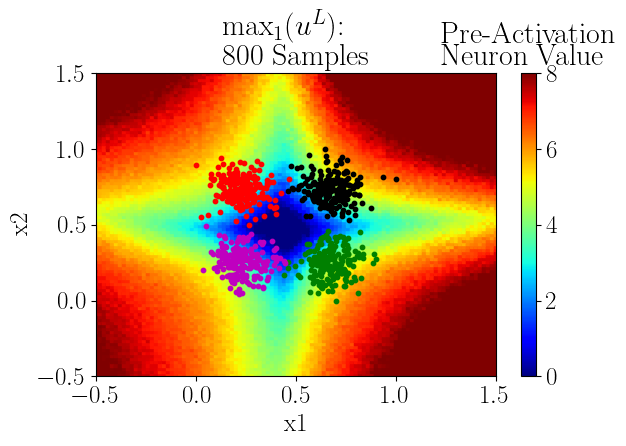

In [74]:
fig, ax = plt.subplots(1, 1)


plt.rcParams['text.usetex'] = True
im = ax.scatter(grid_coords[:, 0], grid_coords[:, 1], c=results[:, 2], s=10, marker="s", cmap=plt.cm.jet, vmin=0, vmax=8)
im = fig.colorbar(im, ax=ax)
im.ax.set_title("Pre-Activation \n Neuron Value")
im.ax.set_ylim([0, 8])

ax.scatter(data_4_200[:n_samples_200, 0], data_4_200[:n_samples_200, 1], s=10, c='r', marker="o", label='Class 1')
ax.scatter(data_4_200[n_samples_200:n_samples_200*2, 0], data_4_200[n_samples_200:n_samples_200*2, 1], s=10, c='black', marker="o", label='Class 2')
ax.scatter(data_4_200[n_samples_200*2:n_samples_200*3, 0], data_4_200[n_samples_200*2:n_samples_200*3, 1], s=10, c='g', marker="o", label='Class 3')
ax.scatter(data_4_200[n_samples_200*3:n_samples_200*4, 0], data_4_200[n_samples_200*3:n_samples_200*4, 1], s=10, c='m', marker="o", label='Class 4')
ax.title.set_text(f"$\max_{1}(u^{'L'})$:\n {800} Samples")
ax.set_xlabel("x1"), ax.set_ylabel("x2")


plt.ylim((-0.5, 1.5))
plt.xlim((-0.5, 1.5))
plt.tight_layout()
plt.show();

### Testing Framework

In [78]:
class testing_framework:
    def __init__(self,
                 X_train_results):
        
        # Training data y_true, y_pred, entropy and pre-activations
        [self.X_train_y_pred,
         self.X_train_entropy_1,
         self.X_train_preacts] = [X_train_results[:, 0],
                                  X_train_results[:, 1],
                                  X_train_results[:, 2:]] 
        
   
        
        self.results = pd.DataFrame()
        self.FDR_results = pd.DataFrame()
        self.POWER_results = pd.DataFrame()
        self.ACC_results = pd.DataFrame()
        self.times = pd.DataFrame()
        self.ood_or_ib = pd.DataFrame()
        
    def new_test(self, 
                 pre_act_data,
                 entropy_data,
                 threshold_pre_act,
                 threshold_entropy,
                 entropy=True,
                 pre_act=True):
        # For storing results
        results = np.zeros(len(pre_act_data))
        # Number of pre-activation samples from training data
        len_X_train = len(self.X_train_preacts[:, 0])
        # Turn pre_activations from training data into absolute values
        train_samples_abs = self.X_train_preacts[:, 0]
        
        # For each test pre-activation test sample
        for idx, (pre_act_i, entropy_i) in enumerate(zip(pre_act_data, entropy_data)):
            
            # Pre-activation test sample
            pre_act_i_abs = np.max(pre_act_i)
            
            
            # Number of pre-activation values from training data the are over pre_act_i_abs 
            n_over = len(train_samples_abs[train_samples_abs > pre_act_i_abs])
            n_under = len(train_samples_abs[train_samples_abs < pre_act_i_abs])
            
            # Divide by number of pre-act values from training data
            self.pvalue_1 = n_over/len_X_train
            self.pvalue_2 = n_under/len_X_train
            
            # If p_value under given threshold, mark as outlier
            if entropy == True and pre_act == True:
                if (self.pvalue_1 < threshold_pre_act) or (self.pvalue_2 < threshold_pre_act) or (entropy_i > threshold_entropy):
                    results[idx] = 1
            elif entropy == False and pre_act == True:
                if (self.pvalue_1 < threshold_pre_act) or (self.pvalue_2 < threshold_pre_act):
                    results[idx] = 1
            elif entropy == True and pre_act == False:
                if (entropy_i > threshold_entropy):
                    results[idx] = 1
            else:
                print("No method.")
                
                
        if entropy == True and pre_act == True:
            self.results[f"PRE-ACT_ENT"] = results
        elif entropy == False and pre_act == True:
            self.results[f"PRE-ACT"] = results
        elif entropy == True and pre_act == False:
            self.results[f"ENT"] = results
                    
        return results
                
    
    @staticmethod
    def POWER_FDR(y_true_out, 
                  y_hatt_out, 
                  y_true_pred, 
                  y_hatt_pred):
        cm = metrics.confusion_matrix(y_true_out, 
                                      y_hatt_out)
        
        preds_true = []
        preds = []
        for y_i_true, y_i_hatt, out in zip(y_true_pred, y_hatt_pred, y_hatt_out):
            if out == 0:
                preds_true.append(y_i_true)
                preds.append(y_i_hatt)
            else:
                pass
                
        
        FP = cm[0, 1]
        TP = cm[0, 0]
        FN = cm[1, 0]
        TN = cm[1, 1]
                
        FDR = FP/(FP+TP)
        POWER = 1 - FN/(TP+FN)
        ACC = accuracy_score(preds_true, preds)

        return [POWER], [FDR], [ACC]
    
    def test_FDR_and_POWER(self, y_true_out, 
                           results_table, 
                           y_pred, 
                           y_hatt_pred):
        for col in results_table.columns:
            [self.POWER_results[col], 
            self.FDR_results[col],
            self.ACC_results[col]] = self.POWER_FDR(y_true_out, 
                                                    results_table[col],
                                                    y_pred, 
                                                    y_hatt_pred)

##### Store predicted class label, entropy and pre-activation neuron values from training data

In [76]:
pr_sim = predict_from_model_sim(net_simulated)
results_train = np.zeros((len(data_4_200[:, 0]), 6))
t = 0

for x, y in zip(data_4_200[:, 0], data_4_200[:, 1]):
    results_train[t, :] = pr_sim.predict([x, y], type_pre_act=1)
    t += 1
        
pd.DataFrame(results_train) 

,0,1,2,3,4,5
0,0.0,0.365372,1.486130,0.633098,-2.536419,-8.923581
1,0.0,0.098383,3.200632,2.285323,-1.354718,-9.973238
2,0.0,0.674351,0.428584,-0.280107,-3.492549,-8.835718
3,0.0,0.405603,1.382706,0.565930,-2.453165,-8.842892
4,0.0,0.062358,3.224510,1.326872,-1.261234,-9.602741
...,...,...,...,...,...,...
795,3.0,0.016515,4.770826,3.323800,-0.933236,-9.597125
796,3.0,0.066197,2.873537,0.860990,-2.423312,-9.099306
797,3.0,0.050401,3.281483,1.252794,-1.875504,-8.813942
798,3.0,0.149143,2.498309,1.398790,-2.659126,-9.171637


##### Test using predictive entropy

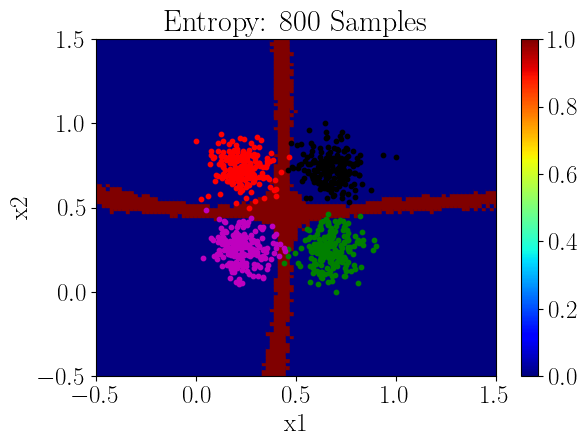

In [79]:
tr_sim = testing_framework(results_train)
res = tr_sim.new_test(results[:, 2:],
                      results[:, 1],
                      0.025,
                      0.6,
                      entropy=True,
                      pre_act=False)

fig, ax = plt.subplots(1, 1)
im = ax.scatter(grid_coords[:, 0], grid_coords[:, 1], c=res, s=10, marker="s", cmap=plt.cm.jet, vmin=0, vmax=1)
im = fig.colorbar(im, ax=ax)

ax.scatter(data_4_200[:n_samples_200, 0], data_4_200[:n_samples_200, 1], s=10, c='r', marker="o", label='Class 1')
ax.scatter(data_4_200[n_samples_200:n_samples_200*2, 0], data_4_200[n_samples_200:n_samples_200*2, 1], s=10, c='black', marker="o", label='Class 2')
ax.scatter(data_4_200[n_samples_200*2:n_samples_200*3, 0], data_4_200[n_samples_200*2:n_samples_200*3, 1], s=10, c='g', marker="o", label='Class 3')
ax.scatter(data_4_200[n_samples_200*3:n_samples_200*4, 0], data_4_200[n_samples_200*3:n_samples_200*4, 1], s=10, c='m', marker="o", label='Class 4')
ax.title.set_text(f"Entropy: {800} Samples")
ax.set_xlabel("x1"), ax.set_ylabel("x2")

plt.ylim((-0.5, 1.5))
plt.xlim((-0.5, 1.5))
plt.tight_layout()
plt.show();

##### Test using pre-activation neuron values

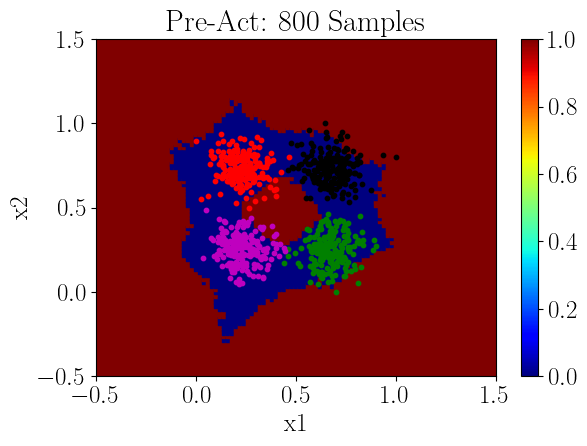

In [80]:
tr_sim = testing_framework(results_train)
res = tr_sim.new_test(results[:, 2:],
                      results[:, 1],
                      0.025,
                      0.6,
                      entropy=False,
                      pre_act=True)

fig, ax = plt.subplots(1, 1)
im = ax.scatter(grid_coords[:, 0], grid_coords[:, 1], c=res, s=10, marker="s", cmap=plt.cm.jet, vmin=0, vmax=1)
im = fig.colorbar(im, ax=ax)

ax.scatter(data_4_200[:n_samples_200, 0], data_4_200[:n_samples_200, 1], s=10, c='r', marker="o", label='Class 1')
ax.scatter(data_4_200[n_samples_200:n_samples_200*2, 0], data_4_200[n_samples_200:n_samples_200*2, 1], s=10, c='black', marker="o", label='Class 2')
ax.scatter(data_4_200[n_samples_200*2:n_samples_200*3, 0], data_4_200[n_samples_200*2:n_samples_200*3, 1], s=10, c='g', marker="o", label='Class 3')
ax.scatter(data_4_200[n_samples_200*3:n_samples_200*4, 0], data_4_200[n_samples_200*3:n_samples_200*4, 1], s=10, c='m', marker="o", label='Class 4')
ax.title.set_text(f"Pre-Act: {800} Samples")
ax.set_xlabel("x1"), ax.set_ylabel("x2")

plt.ylim((-0.5, 1.5))
plt.xlim((-0.5, 1.5))
plt.tight_layout()
plt.show();

##### Test using predictive entropy and pre-activation neuron values

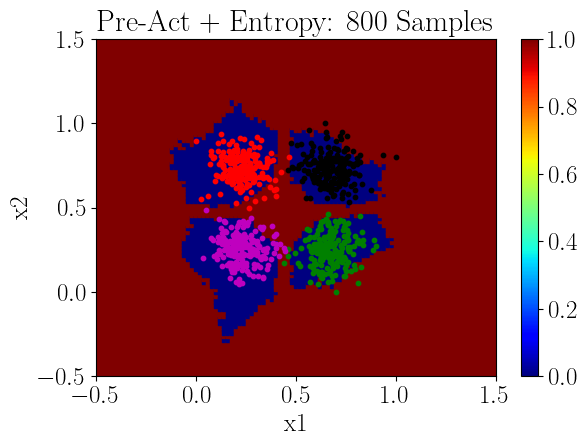

In [81]:
tr_sim = testing_framework(results_train)
res = tr_sim.new_test(results[:, 2:],
                      results[:, 1],
                      0.025,
                      0.6,
                      entropy=True,
                      pre_act=True)

fig, ax = plt.subplots(1, 1)
im = ax.scatter(grid_coords[:, 0], grid_coords[:, 1], c=res, s=10, marker="s", cmap=plt.cm.jet, vmin=0, vmax=1)
im = fig.colorbar(im, ax=ax)

ax.scatter(data_4_200[:n_samples_200, 0], data_4_200[:n_samples_200, 1], s=10, c='r', marker="o", label='Class 1')
ax.scatter(data_4_200[n_samples_200:n_samples_200*2, 0], data_4_200[n_samples_200:n_samples_200*2, 1], s=10, c='black', marker="o", label='Class 2')
ax.scatter(data_4_200[n_samples_200*2:n_samples_200*3, 0], data_4_200[n_samples_200*2:n_samples_200*3, 1], s=10, c='g', marker="o", label='Class 3')
ax.scatter(data_4_200[n_samples_200*3:n_samples_200*4, 0], data_4_200[n_samples_200*3:n_samples_200*4, 1], s=10, c='m', marker="o", label='Class 4')
ax.title.set_text(f"Pre-Act + Entropy: {800} Samples")
ax.set_xlabel("x1"), ax.set_ylabel("x2")

plt.ylim((-0.5, 1.5))
plt.xlim((-0.5, 1.5))
plt.tight_layout()
plt.show();

##### Test performance on test data

In [86]:
minmaxscaler = MinMaxScaler(feature_range=(0, 1))

X = data_4_200_unscaled[:, :2]
y = data_4_200_unscaled[:, 2]


minmaxscaler.fit(X)
X = minmaxscaler.transform(X)
X, y = torch.from_numpy(X).float(), torch.from_numpy(y).long() 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=10, stratify=y)
X_train.shape, y_train.shape

# Concatenate test data from training data distribution and simulated outlier
test_data = np.concatenate((X_test, ood_and_ib[:, :2]), axis=0)
# Mark test data from training data distribution as non-outlier and simulated outliers outliers
y_true_out = [*np.zeros(len(X_test)), *np.ones(len(ood_and_ib))]
# True class label for test data from training data distribution and set a class label for outliers thats not in training data.
y_true_pred = [*y_test, *[5 for _ in range(len(ood_and_ib))]]

(torch.Size([640, 2]), torch.Size([640]))

In [96]:
pr_sim = predict_from_model_sim(net_simulated)
# For storing resuls
results_test_data = np.zeros((len(test_data[:, 0]), 6))
t = 0

# Store predicted class label, entropy and pre-activation neuron values from test data
for x, y in zip(test_data[:, 0], test_data[:, 1]):
    results_test_data[t, :] = pr_sim.predict([x, y], type_pre_act=1)
    t += 1
      
# Predicted class labels 
y_hatt_pred = results_test_data[:, 0]

In [93]:
tr_sim = testing_framework(results_train)


# Using only pre-activation neuron values
res = tr_sim.new_test(results_test_data[:, 2:],
                      results_test_data[:, 1],
                      0.025,
                      0.6,
                      entropy=False,
                      pre_act=True)

# Using only predictive entropy
res = tr_sim.new_test(results_test_data[:, 2:],
                      results_test_data[:, 1], #
                      0.025,
                      0.6,
                      entropy=True,
                      pre_act=False)

# Using pre-activation values and entropy
res = tr_sim.new_test(results_test_data[:, 2:],
                      results_test_data[:, 1],
                      0.025,
                      0.6,
                      entropy=True,
                      pre_act=True)

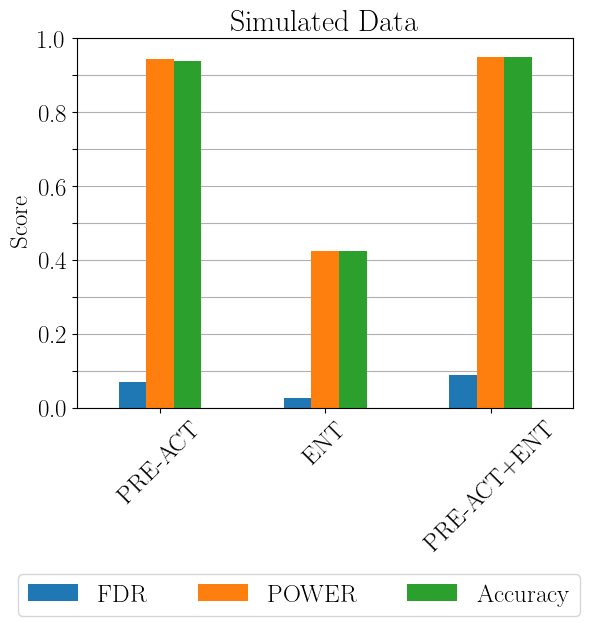

In [95]:
fig, ax = plt.subplots(nrows=1, ncols=1)

tr_sim.test_FDR_and_POWER(y_true_out, 
                            tr_sim.results,
                            y_true_pred,
                            y_hatt_pred)

test_df = pd.concat((tr_sim.FDR_results, tr_sim.POWER_results, tr_sim.ACC_results))

test_df.T.plot.bar(title="Simulated Data", ax=ax)

ax.set_axisbelow(True)
ax.grid(axis='y')
ax.get_legend().remove()
ax.set_xticklabels(["PRE-ACT", "ENT", "PRE-ACT+ENT"], rotation=45)
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                   [0.0, " ", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])


labels=["FDR", "POWER", "Accuracy"]
fig.legend(labels, loc='lower right', bbox_to_anchor=(0.93,-0.35), ncol=len(labels), bbox_transform=fig.transFigure)
fig.text(0.02, 0.5, 'Score', va='center', rotation='vertical')
plt.show()